In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import math

%matplotlib inline

In [22]:
# Default Sobel kernel size
SOBEL_KERNEL_SIZE = 3

# 
SAT_THRESH = (6, 220) # 170, 255

MAG_THRESH = (15, 255) # 0, 255
DIR_THRESH = (0.4, 1.5) # 0.7, 1.3
SOBEL_ORIENT = 'x'
SOBEL_THRESH = (12, 100)

TRANSFORM_SRC = np.array([
    [613, 439],
    [666, 439],
    [260, 681],
    [1050, 681]
], dtype=np.float32)

TRANSFORM_DST = np.array([
    [361, 0],
    [963, 0],
    [361, 720],
    [963, 720]
], dtype=np.float32)

TRANSFORM = cv2.getPerspectiveTransform(TRANSFORM_SRC, TRANSFORM_DST)

In [3]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, thresh=DIR_THRESH):
    
    # Apply the following steps to img
    # 2) Take the gradient in x and y separately
    sb_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=SOBEL_KERNEL_SIZE)
    sb_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=SOBEL_KERNEL_SIZE)
    # 3) Take the absolute value of the x and y gradients
    sb_x = np.absolute(sb_x)
    sb_y = np.absolute(sb_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grads = np.arctan2(sb_y, sb_x)
    # 5) Create a binary mask where direction thresholds are met
    mask = np.zeros_like(grads)
    mask[ (grads >= thresh[0]) & (grads < thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mask


# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=SOBEL_KERNEL_SIZE, mag_thresh=MAG_THRESH):
    
    # Apply the following steps to img
    # 2) Take the gradient in x and y separately
    sb_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sb_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    sb_m = np.sqrt( sb_x ** 2 + sb_y ** 2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    sb_m = np.uint8( sb_m / np.max(sb_m) * 255 )
    # 5) Create a binary mask where mag thresholds are met
    mask = np.zeros_like(sb_m)
    
    mask[ (sb_m >= mag_thresh[0]) & (sb_m < mag_thresh[1]) ] = 1
    # 6) Return this mask as your binary_output image
    return mask
    
def abs_sobel_thresh(img, orient='x', sobel_kernel=SOBEL_KERNEL_SIZE, thresh=SOBEL_THRESH):
    
    # Apply the following steps to img
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x': 
        sobeled = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobeled = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the derivative or gradient
    sobeled = np.absolute(sobeled)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    sobeled = np.uint8(sobeled / np.max(sobeled) * 255.0)
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    mask = np.zeros_like(sobeled)
    mask[(sobeled > thresh[0]) & (sobeled < thresh[1])] = 1
    
    return mask

def thresh(img, thresh=SAT_THRESH):
    mask = np.zeros_like(img)
    mask[(img >= thresh[0]) & (img < thresh[1])] = 1
    return mask

In [64]:
def thresh_pipeline(img):
    hls   = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    b_sblx = abs_sobel_thresh(s_channel, 'x', 3, (3, 255))
    b_sbly = abs_sobel_thresh(s_channel, 'y', 3, (3, 255))
    
    b_mag = mag_thresh(s_channel, 5, (15, 255))
    b_dir = dir_threshold(s_channel, (0.7, 3))
    
    s_thr = thresh(s_channel)
    
    mask = np.zeros_like(s_channel)
    mask[(s_thr == 1) & (b_mag == 1) & ( (b_sbly == 1) | (b_sblx == 1) )] = 1
    
    return mask

def transform_pipeline(img):
    img = cv2.warpPerspective(img, TRANSFORM, (img.shape[1], img.shape[0]))
    return img

def draw_transform_coords(img, coords):
    img = cv2.line(img, tuple(coords[0]), tuple(coords[1]), (255,0,0))
    img = cv2.line(img, tuple(coords[1]), tuple(coords[3]), (255,0,0))
    img = cv2.line(img, tuple(coords[3]), tuple(coords[2]), (255,0,0))
    img = cv2.line(img, tuple(coords[2]), tuple(coords[0]), (255,0,0))
    return img

def pipeline(img): 
    img = thresh_pipeline(img)
    img = transform_pipeline(img)
    return img

In [30]:
imnames = ["test_images/straight_lines1.jpg", "test_images/test2.jpg", "test_images/test3.jpg", "test_images/test4.jpg"]
images = [mpimg.imread(i) for i in imnames]

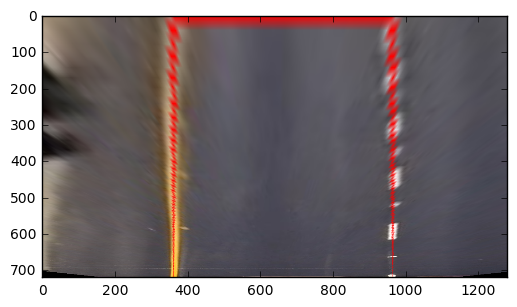

In [31]:
img_annot = np.copy(images[0])
img_annot = draw_transform_coords(img_annot, TRANSFORM_SRC)
img_annot_t = transform_pipeline(img_annot)
plt.imshow(img_annot_t)

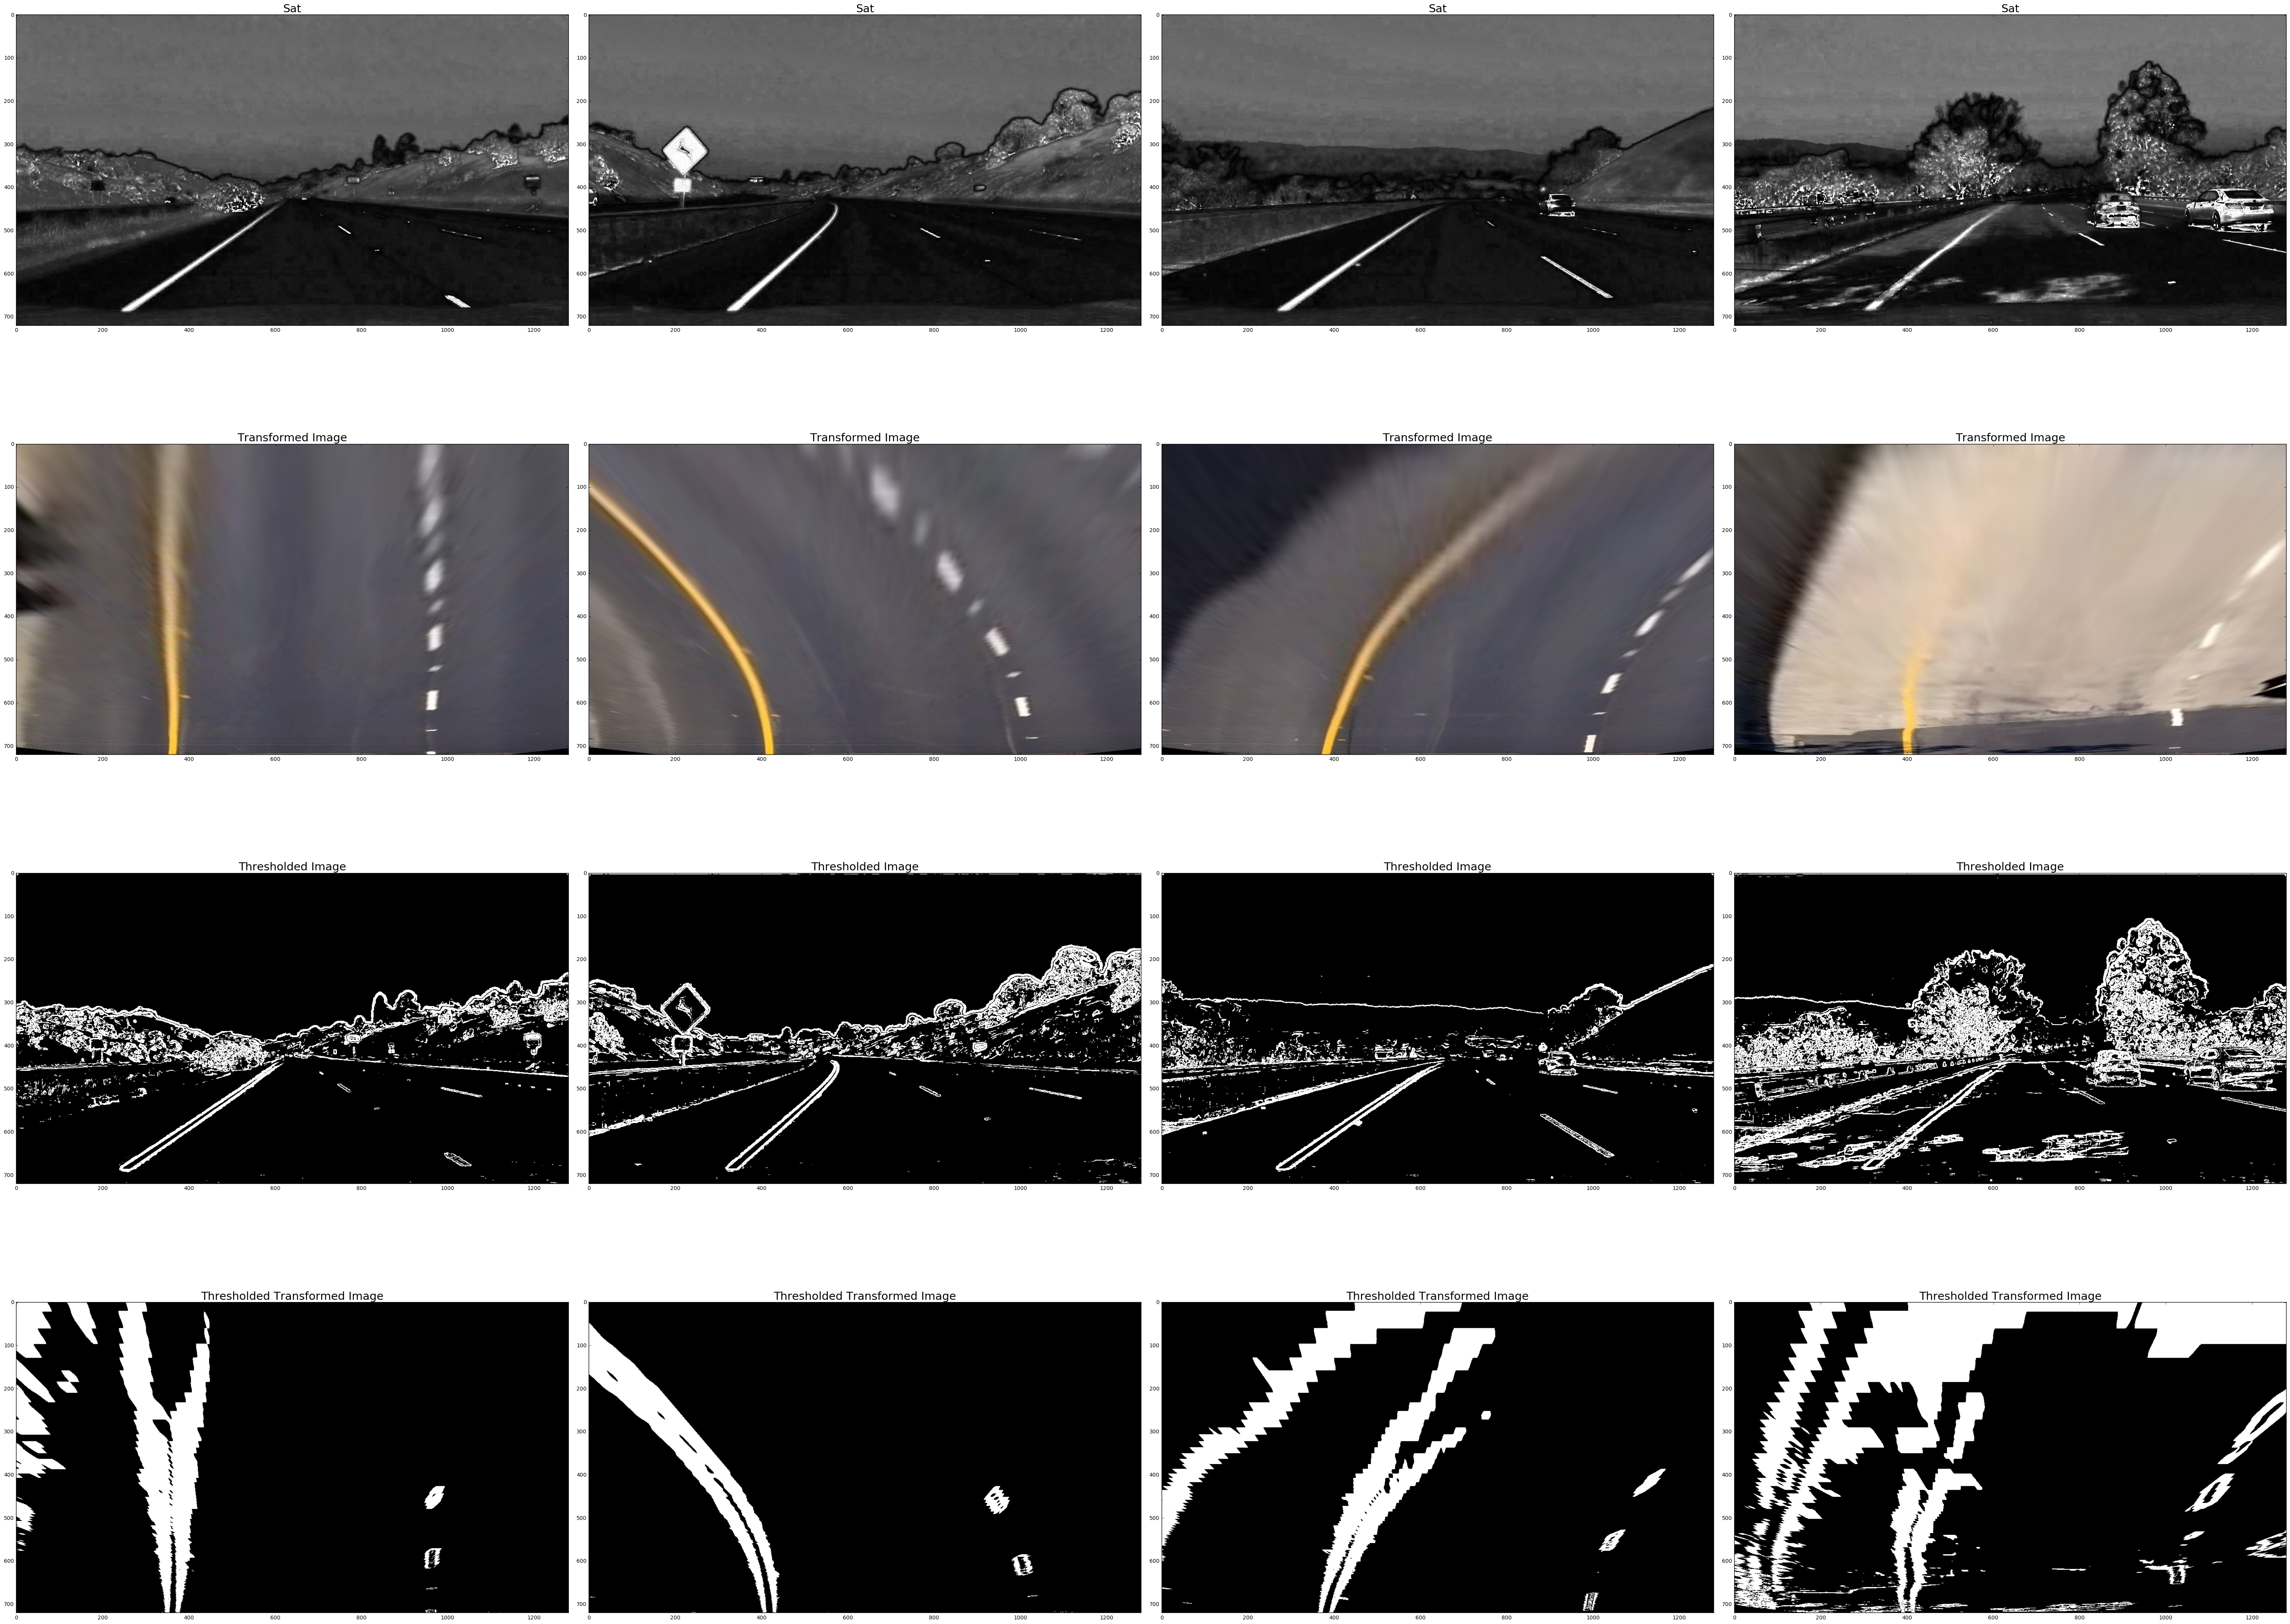

In [66]:
# Plot the result
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 4, figsize=(60, 45))
f.tight_layout()


for i, v in enumerate(images):
    
    sat = cv2.cvtColor(v, cv2.COLOR_RGB2HLS)[:,:,2]
    
    t_tr = transform_pipeline(v)
    t_thresh = thresh_pipeline(v)

    t_trth = pipeline(v)
    
    # 1. Original image
    ax1[i].imshow(sat, cmap='gray')
    ax1[i].set_title('Sat', fontsize=21)

    ax2[i].imshow(t_tr, cmap='gray')
    ax2[i].set_title('Transformed Image', fontsize=21)

    ax3[i].imshow(t_thresh, cmap='gray')
    ax3[i].set_title('Thresholded Image', fontsize=21)

    ax4[i].imshow(t_trth, cmap='gray')
    ax4[i].set_title('Thresholded Transformed Image', fontsize=21)


In [ ]:
# Tests
tf, (tx1, tx2, tx3, tx4, tx5, tx6) = plt.subplots(6, 1, figsize=(7, 22))
tf.tight_layout()

test_sobel = abs_sobel_thresh(saturday, 'x', 3, (6, 220))
tx1.imshow(test_sobel, cmap='gray')

test_mag   = mag_thresh(saturday, 15, (15, 255))
tx2.imshow(test_mag, cmap='gray')

test_dir   = dir_threshold(saturday, (0.6, 1.5))
tx3.imshow(test_dir, cmap='gray')


tx4.imshow((test_sobel == 1) & (test_mag == 1) & (test_dir == 1), cmap='gray')